<html><font size=6><B>3η εργαστηριακή άσκηση</B><BR>
    <BR><B>Link prediction - Πρόβλεψη συνδέσμων</B></BR>
    </font></html>

<html><font size=4><B>1. Κατασκευή γράφου και προεργασία για την πρόβλεψη συνδέσμων</B></font>
    <li><B>1(i).</B> Χρησιμοποιήστε το dataset <a href="http://konect.cc/networks/dbpedia-similar/"> Similarities (DBpedia)</a>, για να κατασκευάσετε τον μη κατευθυνόμενο (undirected) γράφο $G$ <a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]</a>,<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]</a>. Οι κόμβοι του γράφου αναπαριστούν σελίδες της Wikipedia και οι ακμές σχέση ομοιότητας μεταξύ τους. Στην σελίδα <a href="http://konect.cc/networks/dbpedia-similar/"> KONECT (DBpedia)</a> μπορείτε να βρείτε πληροφορίες για τις ιδιότητες του γράφου.</a><BR>
        <B><U>Υπόδειξη:</U></B> Μπορείτε να ελέγξετε προγραμματιστικά αν το dataset περιέχει διπλότυπα των ακμών με την ίδια ή αντίστροφη σειρά (π.χ. ακμές (a,b) και (b,a)), και να λάβετε υπ' όψιν σας αυτήν σας την παρατήρηση, όπου τυχόν χρειαστεί, στην ερώτηση 2.<BR></html>

 <li><B>1(ii).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G$.</li><BR>

In [3]:
import networkx as nx
import pandas as pd
import numpy as np

In [4]:
G: nx.Graph = nx.read_edgelist('dbpedia-similar/out.dbpedia-similar', comments='%')
G.graph['name'] = 'DBpedia Similarities'

In [5]:
# remove self loops
self_loops = nx.selfloop_edges(G)
self_loops_set = set(self_loops)
print(f"Number of self loops removed: {len(self_loops_set)}. Edges removed: {self_loops_set}")
G.remove_edges_from(self_loops_set)


Number of self loops removed: 1. Edges removed: {('420', '420')}


In [6]:
def average_degree(G: nx.Graph):
    sum_of_node_degrees = sum([v for k,v in G.degree()])
    node_count = G.number_of_nodes()
    avg_degree = sum_of_node_degrees/node_count
    return avg_degree

initial_node_count = G.number_of_nodes()
initial_edge_count = nx.number_of_edges(G)
initial_avg_node_degree = average_degree(G)
initial_connected_components = nx.number_connected_components(G)

print(f"Graph: {G.graph['name']}")
print(f"Initial node count: {initial_node_count}")
print(f"Initial edge count: {initial_edge_count}")
print(f"Initial average node degree: {initial_avg_node_degree:.3f}")
print(f"Initial number of connected components: {initial_connected_components}")

Graph: DBpedia Similarities
Initial node count: 430
Initial edge count: 564
Initial average node degree: 2.623
Initial number of connected components: 95


<li><B>1(iii). </B>Υπολογίστε το σύνολο των ασύνδετων ζευγών κόμβων (unconnected pairs) στον γράφο χρησιμοποιώντας τον πίνακα γειτνίασης (adjacency matrix). Δώστε επίσης τον αριθμό τους. Λάβετε υπ' όψιν σας ότι ο γράφος είναι μη κατευθυνόμενος και δεν χρειάζεται να διατρέξετε ολόκληρο τον πίνακα γειτνίασης.</li><BR>

In [7]:
# since graph is undirected, it is symmetrical therefore we just need to check half of the matrix.
# also the diagonal has 0s, since there are no self-loops (one existed initially and was removed)

adj_matrix: np.matrix = nx.to_numpy_matrix(G)

lower_matrix: np.ndarray = np.tril(adj_matrix)

In [8]:
xs_array, ys_array = np.where(lower_matrix == 0)
unconnected_pairs_idxs = list(zip(xs_array, ys_array))
unconnected_pairs_idxs = [(x,y) for x,y in unconnected_pairs_idxs if (y<x)] # filter out the diagonal elements and everything above the diagonal
nodes = np.array(list(G.nodes))
unconnected_pairs_u = nodes[[x for x, _ in unconnected_pairs_idxs]]
unconnected_pairs_v = nodes[[y for _, y in unconnected_pairs_idxs]]
unconnected_pairs = set(zip(unconnected_pairs_u, unconnected_pairs_v))
num_of_unconnected_pairs = len(unconnected_pairs)
print(f"Number of unconnected pairs: {num_of_unconnected_pairs}")


Number of unconnected pairs: 91671


<li><B>1(iv).</B> Υπολογίστε το σύνολο των ακμών (removable edges) που μπορούν να αφαιρεθούν από τον γράφο χωρίς να υπάρχει κατάτμηση (splitting) του γράφου (δηλ. ο αριθμός των συνεκτικών συνιστωσών θα πρέπει να παραμένει αμετάβλητος). Υπόδειξη: Ελέγχετε επίσης ότι με αφαίρεση ακμής δεν μειώνεται ο αριθμός των κόμβων (εφόσον δεν υπάρχει ξεχωριστό αρχείο μόνο με κόμβους στο dataset). Δώστε επίσης τον αριθμό των ακμών (removable edges) που μπορούν να αφαιρεθούν υπό αυτές τις προϋποθέσεις.</li><BR>

In [9]:
def graph_edge_remove(G: nx.Graph, edge_to_remove: tuple) -> nx.Graph:
    G.remove_edge(*edge_to_remove)
    return G

def graph_edge_add(G: nx.Graph, edge_to_add: tuple) -> nx.Graph:
    G.add_edge(*edge_to_add)
    return G

In [10]:
removable_edges = set()

G_removed_edges: nx.Graph = G.copy()

for edge in G.edges:
    graph_edge_remove(G_removed_edges, edge)
    new_conn_components = nx.number_connected_components(G_removed_edges)
    new_G_nodes = G_removed_edges.number_of_nodes()
    if (new_G_nodes == initial_node_count) and (new_conn_components == initial_connected_components):
        removable_edges.add(edge)

    else:
        graph_edge_add(G_removed_edges, edge)

print(f"The number of removable edges of the graph are: {len(removable_edges)}")    

The number of removable edges of the graph are: 229


<li><B>1(vα).</B> Κατασκευάστε dataframe που συνενώνει τις απαντήσεις των ερωτημάτων 1(iii) και 1(iv) (unconnected+removables). Χρησιμοποιήστε την μεταβλητή $link$ που θα παίρνει τιμή 1 ή 0 ανάλογα με την ύπαρξη συνδέσμου ή μη. To dataframe αυτό συγκεντρώνει τα θετικά και αρνητικά δείγματα για την πρόβλεψη των μελλοντικών συνδέσεων (link: target variable). <BR>
    <li><B>1(vβ).</B> Κατασκευάστε τον γράφο $G'$ που προκύπτει από την αφαίρεση από τον γράφο $G$ των ακμών του ερωτήματος 1(iv). <BR>
    <li><B>1(vγ).</B> Εμφανίστε τον αριθμό των κόμβων, τον αριθμό των ακμών, τον μέσο βαθμό των κόμβων και τον αριθμό των συνεκτικών συνιστωσών (connected components) για τον γράφο $G'$.</li><BR>

In [11]:
df = pd.DataFrame({
    'Edge': list(removable_edges) + list(unconnected_pairs),
    'Link': [1] * len(removable_edges) + [0] * len(unconnected_pairs)
    }
)

In [12]:
df.head()

,Edge,Link
0,"(105, 110)",1
1,"(342, 345)",1
2,"(340, 342)",1
3,"(187, 190)",1
4,"(399, 402)",1


In [13]:
G_reduced = G.copy()
G_reduced.graph['name'] = f"{G.graph['name']} reduced"
G_reduced.remove_edges_from(removable_edges)

In [14]:
G_reduced_node_count = G_reduced.number_of_nodes()
G_reduced_edge_count = nx.number_of_edges(G_reduced)
G_reduced_avg_node_degree = average_degree(G_reduced)
G_reduced_connected_components = nx.number_connected_components(G_reduced)

print(f"Graph: {G_reduced.graph['name']}")
print(f"Node count: {G_reduced_node_count}")
print(f"Edge count: {G_reduced_edge_count}")
print(f"Average node degree: {G_reduced_avg_node_degree:.3f}")
print(f"Number of connected components: {G_reduced_connected_components}")

Graph: DBpedia Similarities reduced
Node count: 430
Edge count: 335
Average node degree: 1.558
Number of connected components: 95


   # Εισαγωγή σε similarity-based μετρικές για Link prediction
 - Η μετρική Jaccard Coefficient (JC) των κόμβων $u$ και $v$ ορίζεται ως $\frac{|\Gamma(u) \cap \Gamma(v)|}{|\Gamma(u) \cup \Gamma(v)|}$, όπου ${\Gamma(u)}$ είναι το σύνολο των γειτονικών κόμβων του κόμβου ${u}$.  
- Η μετρική Preferential Αttachment (PA) των κόμβων $u$ και $v$ ορίζεται ως $|\Gamma(u)| |\Gamma(v)|$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.
- Η μετρική Resource Allocation (RA) των κόμβων $u$ και $v$ ορίζεται ως $\sum_{w \in \Gamma(u) \cap \Gamma(v)} \frac{1}{|\Gamma(w)|}$, όπου $\Gamma(u)$ είναι το σύνολο των γειτονικών κόμβων του $u$.

2(i). Για τον γράφο $G'$, που κατασκευάσατε στο ερώτημα 1(vβ), υπολογίστε την μετρική <B>Jaccard Coefficient (JC)</B>.  <a href="https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html?highlight=link%20prediction">Χρησιμοποιήστε την υλοποιημένη συνάρτηση του λογισμικού NetworkX.</a>

2(ii). Δώστε τις $k$ ακμές με την υψηλότερη τιμή μετρικής $JC$, όπου $k$ ο $Α.Μ.$ σας $mod$ $10$. Για $Α.Μ.$ λήγοντα σε $0$ δώστε τις $10$ ακμές με την υψηλότερη τιμή μετρικής.

(Για την σύγκριση μεταξύ διαφορετικών μετρικών προτιμάται η εύρεση των $k$ επικρατέστερων συνδέσμων, αφού οι μετρικές επιστρέφουν διαφορετικό εύρος τιμών.)

2(iii). Προσδιορίστε για την μέτρηση της απόδοσης της μετρικής $JC$ τα μεγέθη $Precision$, $Recall$ και $Accuracy$ και αναπαραστήστε τα γραφικά για τιμές κατωφλίου: $0.1$, $0.15$, $0.25$, $0.5$, $1.0$.  <BR><BR>
    $Precision=\frac{TP}{TP+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα <BR>
    $Recall=\frac{TP}{TP+FN}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα</li> 
    $Accuracy=\frac{TP+TN}{TP+FN+TN+FP}$, όπου $TP$: αληθώς θετικά αποτελέσματα, $TN$: αληθώς αρνητικά αποτελέσματα, $FN$: ψευδώς αρνητικά αποτελέσματα, $FP$: ψευδώς θετικά αποτελέσματα</li><BR><BR>
        <B><U>Υπόδειξη:</U></B>
        Θετικό θεωρήστε ένα αποτέλεσμα, αν η μετρική $JC$ υπερβαίνει μια τιμή κατωφλίου (>=). Αρνητικό θεωρήστε το στην αντίθετη περίπτωση.
        <li>Αληθώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά (η τιμή της $JC$ υπερβαίνει την τιμή κατωφλίου) και πράγματι θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1(iv)).</li>
        <li>Αληθώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά και πράγματι δεν θα υπάρξουν οι συνδέσεις που περιγράφουν (ερ. 1(iii)).</li>
        <li>Ψευδώς θετικά είναι τα αποτελέσματα που βγήκαν θετικά, ενώ δεν θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Ψευδώς αρνητικά είναι τα αποτελέσματα που βγήκαν αρνητικά, ενώ θα υπάρξουν οι συνδέσεις που περιγράφουν.</li>
        <li>Το άθροισμα $TN+FP$ πρέπει κάθε φορά να σας δίνει όλες τις ασύνδετες ακμές του γράφου $G$.</li>   
<li>Από το ερώτημα 1(iii) οι ακμές που υπολογίσατε είναι αυτές για τις οποίες δεν θα υπάρξουν συνδέσεις.</li> <li>Από το ερώτημα 1(iv) οι ακμές που υπολογίσατε είναι αυτές για τις οποίες θα υπάρξουν συνδέσεις.</li><BR></html>

In [15]:
k = 3400131 % 10  # k=1 for the selected student number
jc = nx.jaccard_coefficient(G_reduced)
jc_sorted = sorted(jc, key=lambda x: -x[2])
jc_for_k = jc_sorted[:k]
print(f"The {k} edge(s) with the largest jaccard coefficient is/are:")
for item in jc_for_k:
    print(f"Edge: ({item[0]},{item[1]}), JC: {item[-1]}")

The 1 edge(s) with the largest jaccard coefficient is/are:
Edge: (27,33), JC: 1.0


In [26]:
df[df['Edge'] == ('105', '110')]['Link'][0] == 1

True

In [61]:

def JCfunction(G, threshold_jc):
    ebunch_edges = list(map(lambda x: (x[0], x[1]), df['Edge']))
    jc = nx.jaccard_coefficient(G, ebunch_edges)

    true_links, pred_links = [], []
    for u, v, jcoef in jc:
        pred_link = jcoef >= threshold_jc
        pred_links.append(pred_link)

    true_links = list(df['Link'])

    TP, TN, FP, FN = 0, 0, 0, 0
    
    for i, truth in enumerate(true_links):
        if truth == 1 and truth == pred_links[i]:
            TP += 1
        elif truth == 0 and truth == pred_links[i]:
            TN += 1
        elif truth == 1 and truth != pred_links[i]:
            FN += 1
        else:
            FP += 1

    precision_jc = TP / (TP + FP)
    recall_jc = TP / (TP + FN)
    accuracy_jc = (TP + TN) / (TP + FP + TN + FN)

    return recall_jc, precision_jc, accuracy_jc

In [74]:
thr_range = (0.1, 0.15, 0.25, 0.5, 1.0)
pr, rc, acc = [], [], []
print('Jaccard coefficients - Link prediction')
for jc_threshold in thr_range:
    print(f'Threshold: {jc_threshold}')
    recall, precision, accuracy = JCfunction(G_reduced, jc_threshold)
    pr.append(precision)
    rc.append(recall)
    acc.append(accuracy)
    print(f'\tPrecision: {round(precision, 3)}\n\tRecall: {round(recall, 3)}\n\tAccuracy: {round(accuracy, 3)}')

Jaccard coefficients - Link prediction
Threshold: 0.1
	Precision: 0.321
	Recall: 0.707
	Accuracy: 0.996
Threshold: 0.15
	Precision: 0.324
	Recall: 0.69
	Accuracy: 0.996
Threshold: 0.25
	Precision: 0.346
	Recall: 0.677
	Accuracy: 0.996
Threshold: 0.5
	Precision: 0.417
	Recall: 0.603
	Accuracy: 0.997
Threshold: 1.0
	Precision: 0.51
	Recall: 0.55
	Accuracy: 0.998


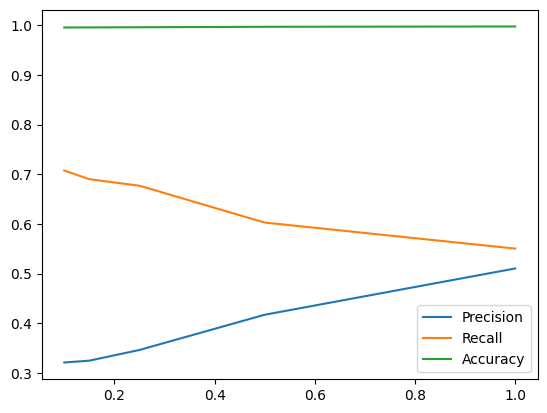

In [75]:
import matplotlib.pyplot as plt

plt.plot(thr_range, pr, label='Precision')
plt.plot(thr_range, rc, label='Recall')
plt.plot(thr_range, acc, label='Accuracy')
plt.legend()
plt.show()

From the printed results and the plot, we can get to the conclusion that the accuracy metric is close to the value of 1 regardless of the selection of jaccard coefficient threshold. This is largely due to the imbalanced nature of the two classes (linked and no linked), where the majority of the nodes are not linked together (no edge exists). Therefore, precision and recall seem to be a better fit as metrics for the given task. 

From the plot, the tradeoff between precision and recall can be clearly observed. For low thresholds, precision is low, which means that there are a lot of FP (false positives), i.e. given that the threshold is low, several edges are classified as linked, where in reality they aren't linked. At the same time, recall is larger compared to other threshold values, which means that FN (false negatives) are low, i.e. since most of the edges are classified/predicted as Positive (linked), then the number of wrong predictions of the Negative (no link) class, is lower.

The conclusions for higher values of the threshold are similar. 

<html><font size=4><B>3. Πρόβλεψη συνδέσμων βάσει similarity-based μετρικών</B></font>    
        <li><B>3(i).</B> Προτείνετε μια τουλάχιστον μέθοδο, για να εξερευνήσουμε και να εκφράσουμε μέσα από τα πακέτα NumPy ή SciPy ή Pandas την συσχέτιση (correlation) μεταξύ των τιμών των μετρικών <B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B> για τον μειωμένο γράφο $G'$. Σημ.: Δεν χρειάζεται κάποια υλοποίηση, μόνο αναφορά της μεθόδου συσχέτισης και επεξήγηση της επιλογής σας.
     <li><B>3(ii).</B> Εργαστείτε πάνω σε <B><U>αντίγραφο</U></B> του dataframe που κατασκευάσατε στο ερώτημα 1(vα) (unconnected+removables). Δημιουργήστε στήλη (column) με τις ακμές του γράφου και θέστε την ως index του dataframe. Στο dataframe θα προσθέσετε ως στήλες τις τιμές των μετρικών (<B>Jaccard Coefficient</B>, <B>Preferential Attachment</B>, <B>Resource Allocation</B>) για τον μειωμένο γράφο $G'$. Οι τιμές των μετρικών μπορούν να υπολογιστούν με τις συναρτήσεις του πακέτου NetworkX.</li>   </font></html>
    
    |       | link  |Jacc.Coeff.|Pr.Attachment| Resource Allocation|
    |-------|-------|-----------|-------------|--------------------|
    |(1, 6) |  0    |  0.333333 |     32      |    0.700000        |
    |(1, 46)|  0    |  0.200000 |      8      |    0.166667        |

For the correlation calculation between the metrics of jaccard coefficient, preferential attachment and resource allocation, the numpy method `np.corrcoef()` can be used. The parameters passed to the method are rowvar=False, for taking rows as records and columns as features as well as a transpose of a multidimensional matrix.

Also, in the pandas library, the `DataFrame.corr()` method computes pairwise Pearson correlations between rows or columns of a DataFrame. By default, the function calculates the Pearson correlation coefficient between the numeric columns of the DataFrame. We can also specify which columns to include in the calculation by passing a list of column names to the `DataFrame.corr()` method, eg. `correlation_matrix = df[["col1", "col2"]].corr()`.

In [83]:
df.head()

,Edge,Link
0,"(105, 110)",1
1,"(342, 345)",1
2,"(340, 342)",1
3,"(187, 190)",1
4,"(399, 402)",1


In [159]:
#replicate of the dataframe "unconnected+removables"---dataframe will be used again in (4)
import copy

df2 = copy.deepcopy(df)
df2.set_index("Edge", inplace=True)
df2.rename_axis(None, inplace=True)
df2.head()

,Link
"(105, 110)",1
"(342, 345)",1
"(340, 342)",1
"(187, 190)",1
"(399, 402)",1


In [160]:
# df.sort_values(by='Edge', key=lambda col: col.map(lambda x: (int(x[0]), int(x[1]))))

In [161]:
ebunch_edges = list(map(lambda x: (x[0], x[1]), df['Edge']))
#dataframe for similarity-based measurement values: df2

#Jaccard Coefficient
jc = nx.jaccard_coefficient(G_reduced, ebunch_edges)
df2['Jacc.Coeff.'] = [x[-1] for x in jc]

#Preferential Attachment
pa = nx.preferential_attachment(G_reduced, ebunch_edges)
df2['Pr.Attachment'] = [x[-1] for x in pa]

#Resource Allocation
ra = nx.resource_allocation_index(G_reduced, ebunch_edges)
df2['Resource Allocation'] = [x[-1] for x in ra]


df2.head()

,Link,Jacc.Coeff.,Pr.Attachment,Resource Allocation
"(105, 110)",1,0.0,2,0.000000
"(342, 345)",1,1.0,1,0.066667
"(340, 342)",1,1.0,1,0.066667
"(187, 190)",1,0.0,2,0.000000
"(399, 402)",1,1.0,1,0.166667


In [162]:
df2.corr()

,Link,Jacc.Coeff.,Pr.Attachment,Resource Allocation
Link,1.000000,0.543554,0.011689,0.254448
Jacc.Coeff.,0.543554,1.000000,-0.015560,0.630806
Pr.Attachment,0.011689,-0.015560,1.000000,0.030255
Resource Allocation,0.254448,0.630806,0.030255,1.000000


It's interesting to notice here that Preferential Attachement has very low correlation with Link, Jaccard Coefficient and Resource Allocation. 
We might expect, based on this observation, that the contribution of the Preferential Attachement feature to the link prediction task will be limited.

In [169]:
# df2.sort_index(key=lambda col: col.map(lambda x: (int(x[0]), int(x[1]))))

<li><B>3(iiiα).</B> Χρησιμοποιήστε τον Random Forest Classifier και το αντίγραφο dataframe που κατασκευάσατε στο ερώτημα 3(ii), για να προβλέψετε συνδέσεις. Συμπληρώστε στον κώδικα: τα features ($X$), την target variable ($y$) και τα ορίσματα της συνάρτησης $fit$ για το training του μοντέλου.</li>
<li><B>3(iiiβ).</B> Δώστε τις ($A.M$ $mod$ $10$) πρώτες προβλέψεις και την ακρίβεια ($accuracy$) του μοντέλου. </li>
<li><B>3(iiiγ).</B>Υπολογίστε την πιθανότητα να συνδεθούν οι κόμβοι ($1$,$47$) βάσει του μοντέλου σας. </li>  

In [199]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
 
X = df2[['Jacc.Coeff.', 'Pr.Attachment', 'Resource Allocation']].to_numpy() # features
y = df2['Link'].to_numpy() # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 0)

print(f'X shape: {X.shape}, type: {X.dtype}')
print(f'\ttrain: {X_train.shape}')
print(f'\ttest : {X_test.shape}')

print(f'y shape: {y.shape}, type: {y.dtype}')
print(f'\ttrain: {y_train.shape}')
print(f'\ttest : {y_test.shape}')


X shape: (91900, 3), type: float64
	train: (61573, 3)
	test : (30327, 3)
y shape: (91900,), type: int64
	train: (61573,)
	test : (30327,)


In [208]:
classifier = RandomForestClassifier()   

from sklearn.preprocessing import MinMaxScaler 
mm_scaler = MinMaxScaler() 
X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

parameters = {'n_estimators' : [10,50,100], 'max_depth' : [5,10,15]} 
model = GridSearchCV(classifier, param_grid = parameters, scoring='f1') 

In [209]:
model.fit(X_train_scaled, y_train) # train the model, uncomment and complete

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [10, 50, 100]},
             scoring='f1')

Given that the dataset is imbalanced, we selected the F1-score as an appropriate scoring metric for the classification task instead of accuracy. The accuracy is expected to be close to 1 without being indicative of the predictive power of our model.

In [227]:
print(f'The best estimator found from Grid Search is {model.best_estimator_}')
print(f'Parameters: {model.best_params_}')
print(f'F1-score = {model.best_score_}')

The best estimator found from Grid Search is RandomForestClassifier(max_depth=15, n_estimators=10)
Parameters: {'max_depth': 15, 'n_estimators': 10}
F1-score = 0.7032989673523181


In [228]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

AM = 3400131
k = AM % 10 # AM mod 10

predictions = model.predict(X_test_scaled)       
k_first_preds = predictions[:k] #get (A.M. last digit) first predictions
k_first_labels = y_test[:k]

print(f'The first {k} prediction(s) is/are: {list(k_first_preds)}\nThe first {k} true label(s) is/are: {list(k_first_labels)}\n')

acc = accuracy_score(y_test, predictions)
pr = precision_score(y_test, predictions)
rc = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print('Prediction metrics:')
print(f'Accuracy : {round(acc, 4)}\nPrecision: {round(pr, 4)}\nRecall   : {round(rc, 4)}\nF1-score : {round(f1, 4)}')

The first 1 prediction(s) is/are: [0]
The first 1 true label(s) is/are: [0]

Prediction metrics:
Accuracy : 0.9986
Precision: 0.8649
Recall   : 0.4638
F1-score : 0.6038


In [268]:
np.reshape(train_sample, (3,)).shape, np.reshape(train_sample, (1, -1)).shape

((3,), (1, 3))

In [305]:
u, v = '1', '47' # nodes for which to make an link prediction (whether an edge exists in graph or no)

train_sample = df2[df2.index == (v, u)].iloc[:, 1:].to_numpy()
train_sample = np.reshape(train_sample, (1, -1)) # reshape to (3,1) numpy array

predict_proba = model.predict_proba(train_sample)

print(f'The probability that nodes {u} and {v} are connected/linked with an edge is predicted by the classifier to be: {predict_proba[0, 1]}')

The probability that nodes 1 and 47 are connected/linked with an edge is predicted by the classifier to be: 0.0


<html><font size=4><B>4. Πρόβλεψη συνδέσμων με embedding βασισμένο σε τυχαίους περιπάτους (Random Walks) </B></font><BR><BR>
    <li><B>4(i).</B> Εξάγετε τα χαρακτηριστικά (features) του γράφου $G'$, που προέκυψε από την αφαίρεση των ακμών. Για τον σκοπό αυτό χρησιμοποιήστε τον αλγόριθμο <B>Node2vec</B> <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a>. Ο αλγόριθμος αντιστοιχίζει τους κόμβους του γράφου μέσω τυχαίων περιπάτων (biased 2nd order random walks) σε ένα χώρο μικρού αριθμού διαστάσεων (low dimensional space) διατηρώντας την μεταξύ τους γειτνίαση.
        <BR>Για την επιλογή των παραμέτρων: 
            <li>p - παράμετρος τυχαίων περιπάτων p που καθορίζει την πιθανότητα “1/p” επιστροφής στον κόμβο προέλευσης (source node), </li>
                <li>q - παράμετρος τυχαίων περιπάτων q που καθορίζει την πιθανότητα  “1/q” μετακίνησης σε κόμβο μακριά από τον κόμβο προέλευσης (source node), </li>
                 <li>dimensions - πλήθος διαστάσεων των Node2Vec embeddings, </li>
                     <li>num_walks - αριθμός περιπάτων από κάθε κόμβο, </li>
                         <li>walk_length - μήκος τυχαίου περιπάτου, </li>
                             <li>window_size - μέγεθος παραθύρου context για τον αλγόριθμο Word2Vec, </li><li>num_iter - αριθμός SGD επαναλήψεων (epochs), </li>
            <li>workers - αριθμός workers για τον Word2Vec,</li>
            χρησιμοποιήστε τις τιμές:   </html>
   
                   

 |   p   |   q   | dimensions|  num_walks  |walk_length |window_size|        workers            |
 |-------|-------|-----------|-------------|------------|-----------|---------------------------|
 |  1.0  |  1.0  |  128      |     10      |    80      |     10    |multiprocessing.cpu_count()|

In [308]:
# install node2vec with conda / pip
from node2vec import Node2Vec
import multiprocessing

#generate walks
node2vec_walker = Node2Vec(G_reduced, dimensions=128, walk_length=80, num_walks=10, p=1.0, q=1.0, workers=multiprocessing.cpu_count())

#train node2vec model
window_size=10
n2v_model = node2vec_walker.fit(window=window_size, min_count=1)

Computing transition probabilities: 100%|██████████| 430/430 [00:00<00:00, 2375.53it/s]


<html><font>
    <li><B>4(ii).</B> Εφαρμόστε τον αλγόριθμο Random Forest Classifier, για να προβλέψετε τις συνδέσεις.</li><BR>
    <li><B>4(iii).</B> Υπολογίστε την ακρίβεια ($accuracy$) του μοντέλου. </li><BR></font></html>

In [13]:
#apply trained Node2Vec model on each node pair of the dataframe "unconnected+removables"
#uncomment:
#x = [(n2v_model.wv[str(i)]+n2v_model.wv[str(j)]) for i,j in zip(df_with_target_var['node_1'], df_with_target_var['node_2'])]

In [14]:
#X_train, X_test, y_train, y_test = train_test_split(, , random_state = 0)  #uncomment and complete

In [15]:
#uncomment whole cell
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import accuracy_score

#classifier = RandomForestClassifier(max_depth=2, random_state=0) 
#classifier.fit()   #uncomment and complete

<html><font size=4> <B><U>Ερώτηση bonus (+10/100)</U><B>: </font>Για τους binary operators για learning των edge features με τον αλγόριθμο Node2Vec που αναφέρονται στο <a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3]</a> ((α) Average, (β) Hadamard, (γ) Weighted-L1 και (δ) Weighted-L2) τροποποιήστε τoν κώδικά σας και σημειώστε τις παρατηρήσεις σας ως προς την απόδοση του αλγορίθμου.</font></html>

<html><font size=4><B><U>Βιβλιογραφία:</U></B><BR></font>
<a href="https://dl.acm.org/doi/10.1145/2487788.2488173">[1]	Jérôme Kunegis. KONECT – The Koblenz Network Collection. In Proc. Int. Conf. on World Wide Web Companion, pages 1343–1350, 2013.</a><BR>
<a href="https://link.springer.com/chapter/10.1007/978-3-540-76298-0_52">[2]	Sören Auer, Christian Bizer, Georgi Kobilarov, Jens Lehmann, Richard Cyganiak, and Zachary Ives. DBpedia: A nucleus for a web of open data. In Proc. Int. Semant. Web Conf., pages 722–735, 2008.<BR>
<a href="https://cs.stanford.edu/~jure/pubs/node2vec-kdd16.pdf">[3] A. Grover, J. Leskovec, Node2vec: Scalable Feature Learning for Networks. ACM KDD, 2016.</a><BR>
 <a href="https://proceedings.neurips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf">[4] T.Mikolov, I.Sutskever, K.Chen, G.S.Corrado and J.Dean, Distributed representations of words and phrases and their compositionality. In NIPS, 2013.</a><BR></font></html>